<a href="https://colab.research.google.com/github/globalpie271/metalpiles-project/blob/main/ladle_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf

# Выгрузка данных в gdrive/content

Папки, где лежат данные

In [ ]:
PATH = os.path.join('gdrive', r'My Drive', r'Colab Notebooks', 'metalpiles-project')
DATA_PATH = os.path.join(PATH, 'data')
FRAMES_PATH = os.path.join(DATA_PATH, 'pile_frames')
SRC_PATH = os.path.join(PATH, 'src')

Выгрузка данных в gdrive/content

In [ ]:
data_path = glob.glob(os.path.join(FRAMES_PATH, 'data.zip'))[0]
data_path

'gdrive/My Drive/Colab Notebooks/metalpiles-project/data/pile_frames/data.zip'

In [ ]:
import zipfile

extract_dir = ''

with zipfile.ZipFile(data_path, 'r') as zip_ref:
  zip_ref.extractall(extract_dir)

# Подготовка датасета

In [ ]:
data_dir = 'data'
frames_dir = os.path.join(data_dir, 'frames')
labels_dir = os.path.join(data_dir, 'labels')

In [ ]:
data_df = pd.read_csv(glob.glob(os.path.join(labels_dir, 'data_df.csv'))[0])
data_df = data_df.loc[:, data_df.columns!='Unnamed: 0']
data_df.head()

,path,ladle_label
0,120210923001407_550_1.jpg,0
1,120210923001407_550_10.jpg,0
2,120210923001407_550_100.jpg,1
3,120210923001407_550_1000.jpg,1
4,120210923001407_550_1001.jpg,1


In [ ]:
os.mkdir(os.path.join(frames_dir, 'ladle'))
os.mkdir(os.path.join(frames_dir, 'no_ladle'))

for i, row in data_df.iterrows():
  path = row['path']
  ladle_label = row['ladle_label']

  if ladle_label == 1:
    os.replace(os.path.join(frames_dir, path), os.path.join(frames_dir, 'ladle', path))
  else:
    os.replace(os.path.join(frames_dir, path), os.path.join(frames_dir, 'no_ladle', path))

In [ ]:
# help(tf.keras.preprocessing.image.ImageDataGenerator)


In [ ]:
# help(train_datagen.flow_from_directory)

In [ ]:
batch_size = 8

# directory, target_size=(256, 256), color_mode='rgb', 
# classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None,

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    brightness_range = [0.5, 1.0],
    validation_split = 0.2,
    # shear_range = 0.2,
    horizontal_flip = True
    )


train_generator = train_datagen.flow_from_directory(
    directory = frames_dir,
    # labels='inferred',
    classes = ['no_ladle', 'ladle'],
    class_mode="binary",
    # class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    target_size=(2592, 1520),
    shuffle=True,
    seed = 128,
    subset = 'training'
    # validation_split=0.2
    # subset=None,
    # interpolation="bilinear",
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # **kwargs
)

validation_batch_size = 8

validation_generator = train_datagen.flow_from_directory(
    directory = frames_dir,
    # labels='inferred',
    classes = ['no_ladle', 'ladle'],
    class_mode="binary",
    # class_names=None,
    color_mode="rgb",
    target_size=(2592, 1520),
    shuffle=True,
    seed = 128,
    batch_size = validation_batch_size,
    subset = 'validation'
    # validation_split=0.2
    # subset=None,
    # interpolation="bilinear",
    # follow_links=False,
    # crop_to_aspect_ratio=False,
    # **kwargs
)

Found 3626 images belonging to 2 classes.
Found 905 images belonging to 2 classes.


In [ ]:
len(os.listdir(os.path.join(frames_dir,'ladle'))), len(os.listdir(os.path.join(frames_dir,'no_ladle')))

(3552, 979)

In [ ]:
for batch in validation_generator:
  break

In [ ]:
batch[0].shape

(32, 2592, 1520, 3)

In [ ]:
batch[0][1].shape

(2592, 1520, 3)

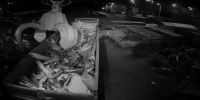

1.0


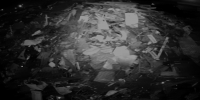

0.0


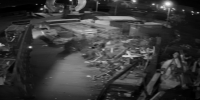

1.0


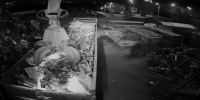

1.0


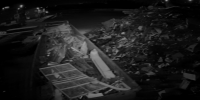

0.0


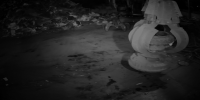

1.0


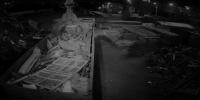

1.0


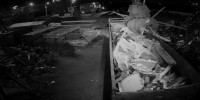

1.0


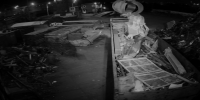

1.0


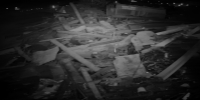

1.0


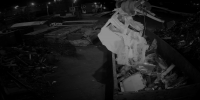

1.0


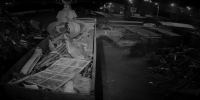

1.0


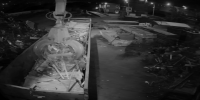

1.0


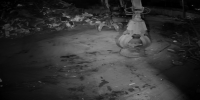

1.0


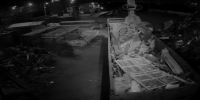

1.0


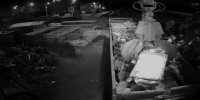

1.0


In [ ]:
from google.colab.patches import cv2_imshow 
import cv2

# print(type(batch[0][1]))

for i in range(batch_size):
  # example = cv2.rotate(batch[0][i], cv2.ROTATE_180)
  example = batch[0][i]
  example = tf.cast(example*255, tf.float32).numpy()
  # exammple = cv2.resize(example, (200, 100))
  example = cv2.resize(example, (200, 100), interpolation = cv2.INTER_AREA)
  cv2_imshow(example)
  print(batch[1][i])

# Обучение

In [ ]:
WIDTH = 2592
HEIGHT = 1520

In [ ]:
from tensorflow.keras.applications import VGG16, Xception, MobileNetV2

# base_model = VGG16(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT,3))
# base_model = Xception(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT,3))
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT,3))
# base_model = 
# base_model.trainable = False

for layer in base_model.layers[:-4]:
  layer.trainable = False  

base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2592, 1520,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 1296, 760, 32 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 1296, 760, 32 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 1296, 760, 32 0           bn_Conv1[0][0]                   
________________

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

input = Input((WIDTH, HEIGHT, 3))
base_output = base_model(input)
# conv_1_1 = Conv2D(1280, (3, 3), activation='relu')(base_output)
# conv_1_2 = Conv2D(1280, (3, 3), activation='relu')(conv_1_1)
pool_1_1 = MaxPooling2D()(base_output)
# pool_1_1 = MaxPooling2D()(conv_1_1)
pool_1_2 = MaxPooling2D()(pool_1_1)
pool_1_3 = MaxPooling2D()(pool_1_2)
pool_1_4 = MaxPooling2D()(pool_1_3)
# conv_2 = Conv2D(1280, (3, 3), activation='relu')(base_output)
# conv_2 = Conv2D(1280, (3, 3), activation='relu')(base_output)
# pool_2 = MaxPooling2D()(conv_1)
flatten = Flatten()(pool_1_4)
# flatten = Flatten()(base_output)
dense = Dense(64, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs = input, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2592, 1520, 3)]   0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 81, 48, 1280)      2257984   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 24, 1280)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 12, 1280)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 6, 1280)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0     

In [ ]:
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [Accuracy(), AUC(), Precision(), Recall()])

In [ ]:
best_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATA_PATH, 'model' + '_best_loss.h5'),
                                monitor='val_loss',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                )
 
last_w = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATA_PATH, 'model' + '_last_loss.h5'),
                                monitor='loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                )
 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
 
callbacks = [best_w, last_w]

In [ ]:
epochs = 10

history = model.fit(train_generator, epochs=epochs, validation_data = validation_generator, callbacks=callbacks)

Epoch 1/10
 61/454 [===>..........................] - ETA: 2:10:16 - loss: 0.2381 - accuracy: 0.5207 - auc: 0.9529 - precision: 0.7697 - recall: 1.0000

KeyboardInterrupt: ignored

# Тест

In [ ]:
model = tf.keras.models.load_model(os.path.join(DATA_PATH, 'model_best_loss.h5'))

In [ ]:
for batch in validation_generator:
  # img = (batch[0] * 255.).astype(np.uint8)
  # prediction = model.predict(batch[0])
  # print(prediction, batch[1])
  break

In [ ]:
batch[0].shape

(8, 2592, 1520, 3)

In [ ]:
# model.weights[-7]

In [ ]:
model.predict(batch[0])

array([[0.5091569 ],
       [0.5091569 ],
       [0.5091569 ],
       [1.        ],
       [0.5091569 ],
       [0.5091569 ],
       [0.9980025 ],
       [0.65201163]], dtype=float32)

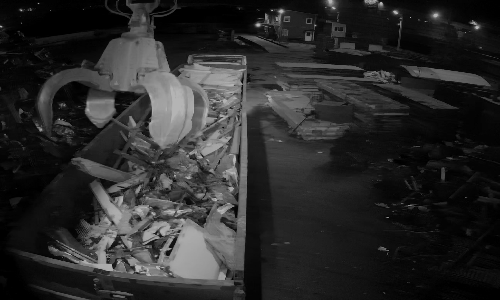

[[0.9999989]] 1.0


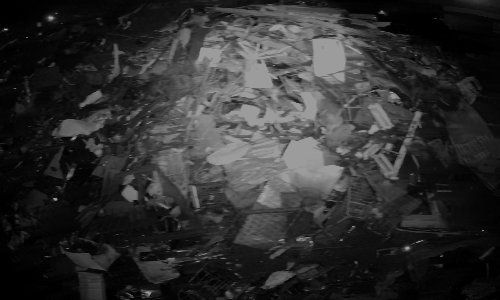

[[0.5003979]] 0.0


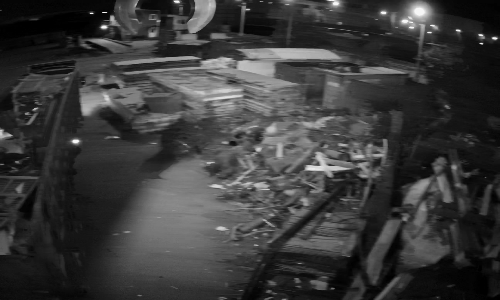

[[0.88590294]] 1.0


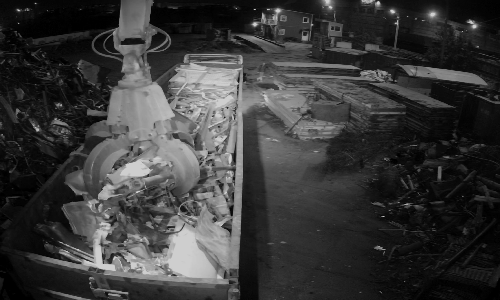

[[1.]] 1.0


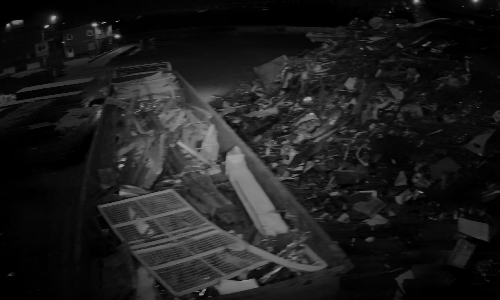

[[0.5003979]] 0.0


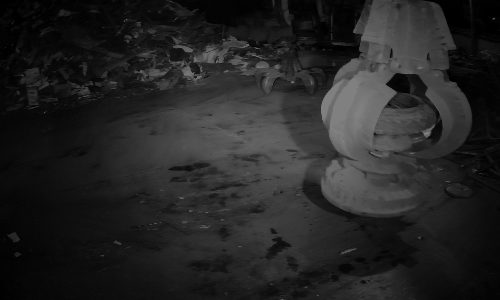

[[0.9978576]] 1.0


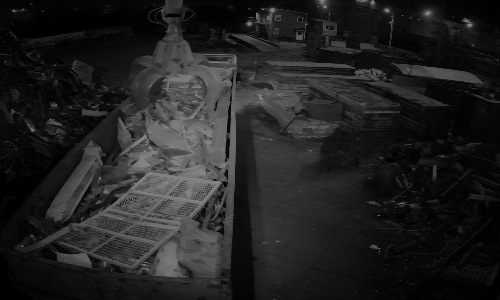

[[1.]] 1.0


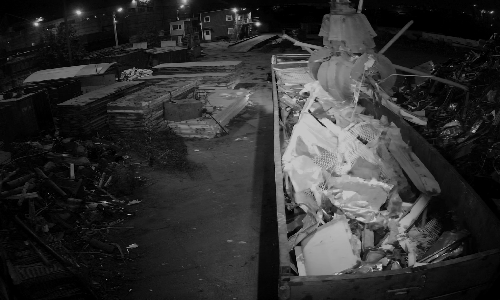

[[0.99996173]] 1.0


In [ ]:
for i in range(batch[0].shape[0]):
  img = cv2.resize((batch[0][i] * 255.).astype(np.uint8), (500, 300))

  cv2_imshow(img)
  print(model.predict(tf.reshape(batch[0][i], (1,WIDTH,HEIGHT, 3))), batch[1][i])

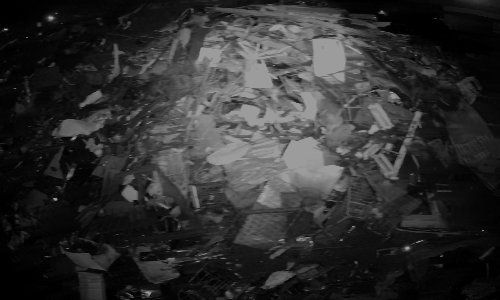

(None, array([[0.5003979]], dtype=float32), 0.0)

In [ ]:
from google.colab.patches import cv2_imshow 
import cv2

i = 1

img = cv2.resize((batch[0][i] * 255.).astype(np.uint8), (500, 300))

cv2_imshow(img), model.predict(tf.reshape(batch[0][i], (1,WIDTH,HEIGHT, 3))), batch[1][i]

# Визуализация

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
last_conv_layer_name = model.layers[-8].name
last_conv_layer_name

'mobilenetv2_1.00_224'

In [ ]:
img_array = tf.reshape(batch[0][0], (1, WIDTH, HEIGHT, 3))
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

ValueError: ignored

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    # img = keras.preprocessing.image.load_img(img_path)
    # img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img, heatmap)